In [140]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from scipy.io import mmread, mmwrite
import matplotlib.pyplot as plt
from scipy import sparse
import plotly.express as px
import random
import math
import seaborn as sns
from plotly import graph_objects as go
import matplotlib.patches as patches

In [141]:
early = pd.read_csv("normalisedXhat_early_methodA.csv")
late = pd.read_csv("normalisedXhat_late_methodA.csv")

In [142]:
early = early[["normX", "normY", "norm", "norm.1"]]
late = late[["normX", "normY", "norm", "norm.1"]]

In [143]:
early = early.rename(columns={"norm":"normEnterprises" , "norm.1":"normEverythingElse"})#"normX":"longitude", "normY":"latitude"
late = late.rename(columns={"norm":"normEnterprises" , "norm.1":"normEverythingElse"})#"normX":"longitude", "normY":"latitude"

In [144]:
# or use?
early = pd.read_csv("Xhat_early.csv")
late = pd.read_csv("Xhat_late.csv")

early = early[['X', 'Y', 'Unnamed: 3', 'Unnamed: 4']]
late = late[['X', 'Y', 'Unnamed: 3', 'Unnamed: 4']]

# these are the wrong names, should be X, Y, Enterprises, Everything else, but then I'd have to change the code more
early = early.rename(columns={"X": "normX", "Y": "normY", "Unnamed: 3":"normEnterprises" , "Unnamed: 4":"normEverythingElse"})
late = late.rename(columns={"X": "normX", "Y": "normY", "Unnamed: 3":"normEnterprises" , "Unnamed: 4":"normEverythingElse"})

In [145]:
LAD_Region_lookup = pd.read_csv("LAD_Region_lookup_UK.csv")

In [146]:
early = pd.concat([early, LAD_Region_lookup], axis=1)
late = pd.concat([late, LAD_Region_lookup], axis=1)

In [147]:
early["NorthIndicator"] = np.where( (early["RGN11NM"] == "South West") | (early["RGN11NM"] == "London") | (early["RGN11NM"] == "South East") | (early["RGN11NM"] == "East of England"), 0, 1) 
late["NorthIndicator"] = np.where( (late["RGN11NM"] == "South West") | (late["RGN11NM"] == "London") | (late["RGN11NM"] == "South East") | (late["RGN11NM"] == "East of England"), 0, 1) 

In [148]:
early = early.drop(columns=(["Unnamed: 0",  "LAD11NM"]))
late = late.drop(columns=(["Unnamed: 0",  "LAD11NM"]))

In [149]:
early['EarlyIndicator'] = 1
late['EarlyIndicator'] = 0

In [150]:
df = early.append(late)

In [151]:
d=4

In [152]:
mean_diff_early = []
mean_diff_late = []

In [153]:
earlyNorthdf = df[ (df["EarlyIndicator"] == 1) & (df["NorthIndicator"] == 1) ]
earlySouthdf = df[ (df["EarlyIndicator"] == 1) & (df["NorthIndicator"] == 0) ]
lateNorthdf = df[ (df["EarlyIndicator"] == 0) & (df["NorthIndicator"] == 1) ]
lateSouthdf = df[ (df["EarlyIndicator"] == 0) & (df["NorthIndicator"] == 0) ]

In [154]:
# how many LADs are in the north
n = early[ (early["NorthIndicator"]==1)].shape[0]
# how many LADs are in the south
s = early[(early["NorthIndicator"]==0)].shape[0]

print([n,s])

[196, 184]


In [155]:
# calculate values of mean_diff_early_i for all i, i.e. all PCs, and store them in order in a vector
# same for mean_diff_late_i

for i in range(0,d):
    valEarly = (n) * sum( earlyNorthdf.iloc[: ,i])  -  (s) * sum( earlySouthdf.iloc[: ,i])
    valLate = (n) * sum( lateNorthdf.iloc[: ,i])  -  (s) * sum( lateSouthdf.iloc[: ,i])
    mean_diff_early.append(valEarly)
    mean_diff_late.append(valLate)

In [156]:
# calculate T_PC_i
T_PC = np.subtract(mean_diff_early, mean_diff_late)

# length d vector of the subtracted values
T_PC

array([-1.15493905e+08, -8.30190323e+08,  8.74310026e+07,  1.74535702e+08])

In [157]:
T_full_obs = sum(T_PC**2) # this is T_obs
T_obs = T_full_obs # incase I type wrong thing
T_full_obs

7.406617067856696e+17

In [158]:
ladslist = list(LAD_Region_lookup['LAD'])

#### Put it all together in a loop that iterates P times, and stores P items in a `T_full_p_list` item. 

In [159]:
rand_ones = np.array([0,1])
df["A_indicator"] = 0

T_full_p_list = []
P = 5000

# for the individual PCs
T_PC_p_table = pd.DataFrame(columns=['normX','normY','normEnterprises','normEverythingElse'])

In [160]:
random.seed(12)

summariesdf = pd.DataFrame()

for p in range(P):

    for lad in ladslist:
        # to pick 1 timepoints at random for group A, and one for B, i.e. randomly assign to either early or late
        random.shuffle(rand_ones)
        # populates the "A_indicator" column
        df.loc[df["LAD"] == lad,"A_indicator"] = rand_ones

# split the data into the 4 groups (made up of 2 binary labels, 2*2 = 4)
    A_Northdf = df[ (df["A_indicator"] == 1) & (df["NorthIndicator"] == 1) ]
    A_Southdf = df[ (df["A_indicator"] == 1) & (df["NorthIndicator"] == 0) ]
    B_Northdf = df[ (df["A_indicator"] == 0) & (df["NorthIndicator"] == 1) ]
    B_Southdf = df[ (df["A_indicator"] == 0) & (df["NorthIndicator"] == 0) ]
    
    ### THIS STUFF IS TO CONSTRUCT CONFIDENCE INTERVALS
    A_North_summaries = [np.mean(A_Northdf['normX']) , np.mean(A_Northdf['normY']) , np.mean(A_Northdf['normEnterprises']) , np.mean(A_Northdf['normEverythingElse'])]
    A_South_summaries = [np.mean(A_Southdf['normX']) , np.mean(A_Southdf['normY']) , np.mean(A_Southdf['normEnterprises']) , np.mean(A_Southdf['normEverythingElse'])]
    B_North_summaries = [np.mean(B_Northdf['normX']) , np.mean(B_Northdf['normY']) , np.mean(B_Northdf['normEnterprises']) , np.mean(B_Northdf['normEverythingElse'])]
    B_South_summaries = [np.mean(B_Southdf['normX']) , np.mean(B_Southdf['normY']) , np.mean(B_Southdf['normEnterprises']) , np.mean(B_Southdf['normEverythingElse'])]
    summaries = pd.DataFrame (A_North_summaries, columns = ['A_North'])
    summaries['A_South'] = A_South_summaries
    summaries['B_North'] = B_North_summaries
    summaries['B_South'] = B_South_summaries
    summaries.index = (['normX','normY','normEnterprises','normEverythingElse'])
    summaries = summaries.transpose()
    summaries['NorthIndicator'] = [1,0,1,0]
    summaries['NorthorSouth'] = np.where(summaries['NorthIndicator'] >0, 'North', 'South')
    summaries['A_Indicator'] = [1,1,0,0]
    summaries['AorB'] = np.where(summaries['A_Indicator'] >0, 'A', 'B')
    summaries['permutation'] = p
    summariesdf = pd.concat([summariesdf, summaries], axis=0)


    # length d vectors of the difference between the mean locations of the North and South for the 2 groups, A and B 
    mean_diff_A_p = []  #A is early, B is late
    mean_diff_B_p = []
    # calculate values of mean_diff_A_i for all i, i.e. all PCs, and store them in order in a vector
    # same for mean_diff_B_i
    for i in range(0,d):
        valA = (n) * sum( A_Northdf.iloc[: ,i])  -  (s) * sum( A_Southdf.iloc[: ,i])
        valB = (n) * sum( B_Northdf.iloc[: ,i])  -  (s) * sum( B_Southdf.iloc[: ,i])
        mean_diff_A_p.append(valA)
        mean_diff_B_p.append(valB)

    # calculate T_PC_i_p
    T_PC_p = np.subtract(mean_diff_A_p, mean_diff_B_p)

    T_full_p = sum(T_PC_p**2) # this is T_obs

    # values for all dimensions statistic 
    T_full_p_list.append(T_full_p)
    
    # values for individual dimension statistic
    T_PC_p_table.loc[p,:] = T_PC_p

In [161]:
# Testing if time matters in each of the 4 dimensions independently
counters_PCs = []
for dim in range(d):
    counter = 0
    for p in range(P):
        if T_PC_p_table.iloc[p , dim] > T_PC[dim]:
            counter += 1
        else: 
            counter = counter
    counters_PCs.append(counter)

PC_p_values = [(x+1) / (P+1) for x in counters_PCs] # (x+1) add 1 as include the observed value
PC_p_values

[0.7266546690661868, 1.0, 0.34913017396520696, 0.244751049790042]

In [162]:
# can square all the values in the `T_PC_p_table` table.
# This is to say we are looking at the value of   (mean_diff_A_p_i - mean_diff_B_p_i)**2
# when we look at row p, column i in the table

T_PC_p_table_squared = T_PC_p_table**2 # #square every value in df

### Histograms for *(mean_diff_A_p_i - mean_diff_B_p_i)$^2$*, where there is a plot for each `i` (the dimension), and `P` counts. 

In [163]:
counters_PCs = []
for dim in range(d):
    counter = 0
    for p in range(P):
        if T_PC_p_table_squared.iloc[p , dim] > (T_PC[dim])**2:
            counter += 1
        else: 
            counter = counter
    counters_PCs.append(counter)

PC_p_square_values = [(x+1) / (P+1) for x in counters_PCs] # (x+1) add 1 as include the observed value

# p-values for each dimension
PC_p_square_values

[0.5576884623075385,
 0.0001999600079984003,
 0.6842631473705258,
 0.5188962207558488]

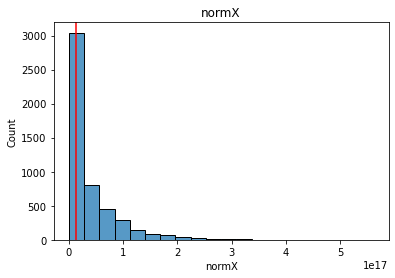

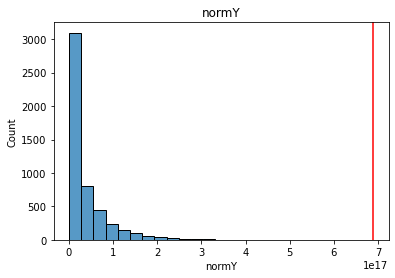

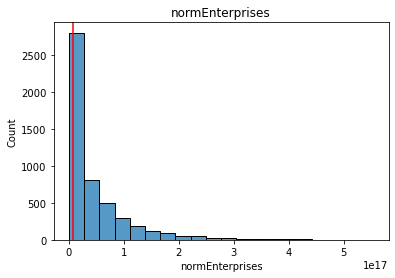

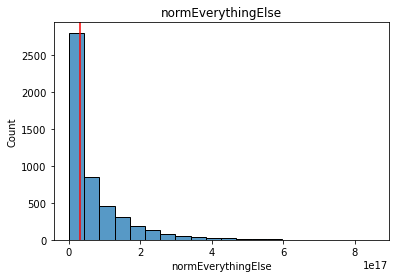

In [164]:
# squared values of distance between mean diff in groups A and B
names = ['normX','normY','normEnterprises','normEverythingElse']

for dim in range(d):
    f, ax = plt.subplots()
    ax = sns.histplot(T_PC_p_table_squared.iloc[:,dim], bins=20)
    plt.axvline( (T_PC[dim])**2 , color="red")
    ax.set_title(names[dim])
    
    fig = ax.get_figure()

#### try and make the plot for fig6, but axis are longitude and latitude
02/05/2023

In [165]:
# north is east, south is west
earlyNorth_summaries = [np.mean(earlyNorthdf['normX']) , np.mean(earlyNorthdf['normY']) , np.mean(earlyNorthdf['normEnterprises']) , np.mean(earlyNorthdf['normEverythingElse'])]
earlySouth_summaries = [np.mean(earlySouthdf['normX']) , np.mean(earlySouthdf['normY']) , np.mean(earlySouthdf['normEnterprises']) , np.mean(earlySouthdf['normEverythingElse'])]
lateNorth_summaries = [np.mean(lateNorthdf['normX']) , np.mean(lateNorthdf['normY']) , np.mean(lateNorthdf['normEnterprises']) , np.mean(lateNorthdf['normEverythingElse'])]
lateSouth_summaries = [np.mean(lateSouthdf['normX']) , np.mean(lateSouthdf['normY']) , np.mean(lateSouthdf['normEnterprises']) , np.mean(lateSouthdf['normEverythingElse'])]

In [166]:
summaries = pd.DataFrame (earlyNorth_summaries, columns = ['earlyNorth'])
summaries['earlySouth'] = earlySouth_summaries
summaries['lateNorth'] = lateNorth_summaries
summaries['lateSouth'] = lateSouth_summaries

summaries.index = (['normX', 'normY' , 'normEnterprises', 'normEverythingElse'])

summaries = summaries.transpose()

summaries['NorthIndicator'] = [1,0,1,0]
# changed northorsouth to eastorwest
summaries['NorthorSouth'] = np.where(summaries['NorthIndicator'] >0, 'North', 'South')
summaries['EarlyIndicator'] = [1,1,0,0]
summaries['EarlyorLate'] = np.where(summaries['EarlyIndicator'] >0, 'Early', 'Late')

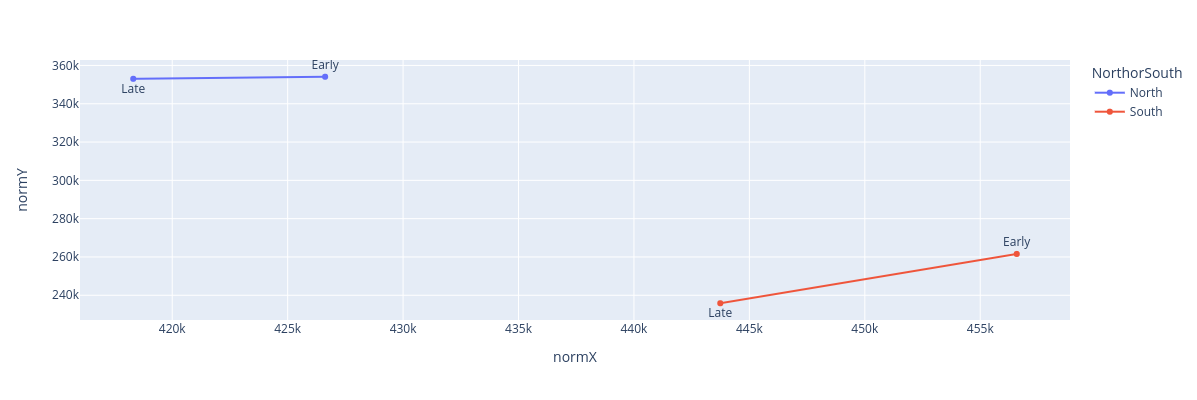

In [167]:
import plotly.express as px

fig = px.line(summaries, x='normX', y='normY', color='NorthorSouth',
              text='EarlyorLate', hover_data=['NorthorSouth', 'EarlyorLate'],
              width=1000, height=400)

fig.update_traces(textposition=['top center', 'bottom center'])

fig.show()

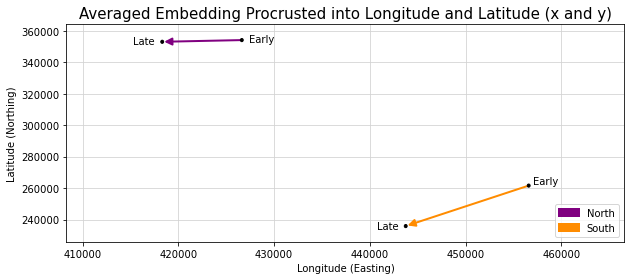

In [168]:
p1 = patches.FancyArrowPatch((summaries['normX'][0], summaries['normY'][0]), (summaries['normX'][2], summaries['normY'][2]), 
                             arrowstyle='-|>', mutation_scale=15, ec="purple", fc="purple", lw=2, label="North")
p2 = patches.FancyArrowPatch((summaries['normX'][1], summaries['normY'][1]), (summaries['normX'][3], summaries['normY'][3]), 
                             arrowstyle='-|>', mutation_scale=15, ec="darkorange", fc="darkorange", lw=2, label="South")

p3 = patches.Ellipse((summaries['normX'][0], summaries['normY'][0]), height=2000, width=300, ec="black", fc="black")
p4 = patches.Ellipse((summaries['normX'][1], summaries['normY'][1]), height=2000, width=300, ec="black", fc="black")
p5= patches.Ellipse((summaries['normX'][2], summaries['normY'][2]), height=2000, width=300, ec="black", fc="black")
p6 = patches.Ellipse((summaries['normX'][3], summaries['normY'][3]), height=2000, width=300, ec="black", fc="black")

fig, ax = plt.subplots(figsize=(10,4))
ax.add_patch(p1)
ax.add_patch(p2)
ax.add_patch(p3)
ax.add_patch(p4)
ax.add_patch(p5)
ax.add_patch(p6)

# adjust the x and y limits of the plot
eps = 10000
ax.set_xlim(min(summaries['normX'])-eps, max(summaries['normX'])+eps)
ax.set_ylim(min(summaries['normY'])-eps, max(summaries['normY'])+eps)

#south
plt.annotate(text="Early", xy = (summaries['normX'][1]+0.05*eps, summaries['normY'][1]+0.1*eps))
plt.annotate(text="Late", xy = (summaries['normX'][3]-0.3*eps, summaries['normY'][3]-0.2*eps))
#north
plt.annotate(text="Early", xy = (summaries['normX'][0]+0.08*eps, summaries['normY'][0]-0.15*eps))
plt.annotate(text="Late", xy = (summaries['normX'][2]-0.3*eps, summaries['normY'][2]-0.15*eps))


#ax.set_facecolor('xkcd:pale blue')

plt.xlabel("Longitude (Easting)")
plt.ylabel("Latitude (Northing)")
plt.title("Averaged Embedding Procrusted into Longitude and Latitude (x and y)", fontsize=15)

plt.legend(loc=4)
ax.set_axisbelow(True)
ax.grid(color="lightgrey")

plt.savefig("NS_earlyLate_lat_long_GB_ConcWins_rectangle_arrows.pdf")

plt.show()

## non-normalised, testing the Urban/rural divide

In [211]:
df = early.append(late)

In [212]:
RUC = pd.read_csv("RUC_LAD_2011_EN_LU.csv")

In [213]:
RUC = RUC[['LAD11CD', 'LAD18NM', 'RUC11CD']]

In [214]:
df = df.merge(RUC, left_on="LAD", right_on="LAD18NM", how="left")

Change the NorthIndicator, so now this represents Urban (urban= north)

In [215]:
scot = pd.read_csv("Scotland_2016_LAD_population8fold_UR_classifications.csv")

In [216]:
scot["sum1_2"] = scot['Large Urban Areas'] + scot['Other Urban Areas']
# I define "urban" as the top 2 out of 8 urban classifiers

In [217]:
scot2 = scot[["Local Authority", "sum1_2"]]

In [218]:
df = df.merge(scot2, left_on="LAD", right_on="Local Authority", how="left")

In [219]:
df = df.drop(columns={'LAD11CD_x', 'Local Authority', 'LAD11CD_y'})

In [220]:
df["NorthIndicator"] = np.where( (df['RUC11CD'] > 4) | (df['sum1_2'] >= 90.0) | (df['LAD']=="Swansea") | (df['LAD']=="Cardiff") |(df['LAD']=="Newport") , 1 ,0) 
# has to have all conditions, for Scotland, 

In [221]:
# how many LADs are in the north = urban
n = df[(df["EarlyIndicator"]==1) & (df["NorthIndicator"]==1)].shape[0]
# how many LADs are in the rural
s = df[(df["EarlyIndicator"]==1) & (df["NorthIndicator"]==0)].shape[0]

print([n,s])

[92, 288]


In [222]:
mean_diff_early = []
mean_diff_late = []

In [223]:
earlyNorthdf = df[ (df["EarlyIndicator"] == 1) & (df["NorthIndicator"] == 1) ]
earlySouthdf = df[ (df["EarlyIndicator"] == 1) & (df["NorthIndicator"] == 0) ]
lateNorthdf = df[ (df["EarlyIndicator"] == 0) & (df["NorthIndicator"] == 1) ]
lateSouthdf = df[ (df["EarlyIndicator"] == 0) & (df["NorthIndicator"] == 0) ]

In [224]:
# calculate values of mean_diff_early_i for all i, i.e. all PCs, and store them in order in a vector
# same for mean_diff_late_i

for i in range(0,d):
    valEarly = (n) * sum( earlyNorthdf.iloc[: ,i])  -  (s) * sum( earlySouthdf.iloc[: ,i])
    valLate = (n) * sum( lateNorthdf.iloc[: ,i])  -  (s) * sum( lateSouthdf.iloc[: ,i])
    mean_diff_early.append(valEarly)
    mean_diff_late.append(valLate)

In [225]:
# calculate T_PC_i
T_PC = np.subtract(mean_diff_early, mean_diff_late)

# length d vector of the subtracted values
T_PC

array([-1.12771006e+09, -7.66781372e+08, -3.39589989e+08,  2.08523708e+08])

In [226]:
T_full_obs = sum(T_PC**2) # this is T_obs
T_obs = T_full_obs # incase I type wrong thing
T_full_obs

2.0184871575955535e+18

#### Put it all together in a loop that iterates P times, and stores P items in a `T_full_p_list` item. 

In [227]:
rand_ones = np.array([0,1])
df["A_indicator"] = 0

T_full_p_list = []
P = 1000

# for the individual PCs
T_PC_p_table = pd.DataFrame(columns=['normX','normY','normEnterprises','normEverythingElse'])

In [228]:
random.seed(12)

summariesdf = pd.DataFrame()

for p in range(P):

    for lad in ladslist:
        # to pick 1 timepoints at random for group A, and one for B, i.e. randomly assign to either early or late
        random.shuffle(rand_ones)
        # populates the "A_indicator" column
        df.loc[df["LAD"] == lad,"A_indicator"] = rand_ones

# split the data into the 4 groups (made up of 2 binary labels, 2*2 = 4)
    A_Northdf = df[ (df["A_indicator"] == 1) & (df["NorthIndicator"] == 1) ]
    A_Southdf = df[ (df["A_indicator"] == 1) & (df["NorthIndicator"] == 0) ]
    B_Northdf = df[ (df["A_indicator"] == 0) & (df["NorthIndicator"] == 1) ]
    B_Southdf = df[ (df["A_indicator"] == 0) & (df["NorthIndicator"] == 0) ]
    
    ### THIS STUFF IS TO CONSTRUCT CONFIDENCE INTERVALS
    A_North_summaries = [np.mean(A_Northdf['normX']) , np.mean(A_Northdf['normY']) , np.mean(A_Northdf['normEnterprises']) , np.mean(A_Northdf['normEverythingElse'])]
    A_South_summaries = [np.mean(A_Southdf['normX']) , np.mean(A_Southdf['normY']) , np.mean(A_Southdf['normEnterprises']) , np.mean(A_Southdf['normEverythingElse'])]
    B_North_summaries = [np.mean(B_Northdf['normX']) , np.mean(B_Northdf['normY']) , np.mean(B_Northdf['normEnterprises']) , np.mean(B_Northdf['normEverythingElse'])]
    B_South_summaries = [np.mean(B_Southdf['normX']) , np.mean(B_Southdf['normY']) , np.mean(B_Southdf['normEnterprises']) , np.mean(B_Southdf['normEverythingElse'])]
    summaries = pd.DataFrame (A_North_summaries, columns = ['A_North'])
    summaries['A_South'] = A_South_summaries
    summaries['B_North'] = B_North_summaries
    summaries['B_South'] = B_South_summaries
    summaries.index = (['normX','normY','normEnterprises','normEverythingElse'])
    summaries = summaries.transpose()
    summaries['NorthIndicator'] = [1,0,1,0]
    summaries['NorthorSouth'] = np.where(summaries['NorthIndicator'] >0, 'North', 'South')
    summaries['A_Indicator'] = [1,1,0,0]
    summaries['AorB'] = np.where(summaries['A_Indicator'] >0, 'A', 'B')
    summaries['permutation'] = p
    summariesdf = pd.concat([summariesdf, summaries], axis=0)


    # length d vectors of the difference between the mean locations of the North and South for the 2 groups, A and B 
    mean_diff_A_p = []  #A is early, B is late
    mean_diff_B_p = []
    # calculate values of mean_diff_A_i for all i, i.e. all PCs, and store them in order in a vector
    # same for mean_diff_B_i
    for i in range(0,d):
        valA = (n) * sum( A_Northdf.iloc[: ,i])  -  (s) * sum( A_Southdf.iloc[: ,i])
        valB = (n) * sum( B_Northdf.iloc[: ,i])  -  (s) * sum( B_Southdf.iloc[: ,i])
        mean_diff_A_p.append(valA)
        mean_diff_B_p.append(valB)

    # calculate T_PC_i_p
    T_PC_p = np.subtract(mean_diff_A_p, mean_diff_B_p)

    T_full_p = sum(T_PC_p**2) # this is T_obs

    # values for all dimensions statistic 
    T_full_p_list.append(T_full_p)
    
    # values for individual dimension statistic
    T_PC_p_table.loc[p,:] = T_PC_p

In [229]:
# Testing if time matters in each of the 4 dimensions independently
counters_PCs = []
for dim in range(d):
    counter = 0
    for p in range(P):
        if T_PC_p_table.iloc[p , dim] > T_PC[dim]:
            counter += 1
        else: 
            counter = counter
    counters_PCs.append(counter)

PC_p_values = [(x+1) / (P+1) for x in counters_PCs] # (x+1) add 1 as include the observed value
PC_p_values

[1.0, 0.998001998001998, 0.8711288711288712, 0.2907092907092907]

In [230]:
# can square all the values in the `T_PC_p_table` table.
# This is to say we are looking at the value of   (mean_diff_A_p_i - mean_diff_B_p_i)**2
# when we look at row p, column i in the table

T_PC_p_table_squared = T_PC_p_table**2 # #square every value in df

### Histograms for *(mean_diff_A_p_i - mean_diff_B_p_i)$^2$*, where there is a plot for each `i` (the dimension), and `P` counts. 

In [231]:
counters_PCs = []
for dim in range(d):
    counter = 0
    for p in range(P):
        if T_PC_p_table_squared.iloc[p , dim] > (T_PC[dim])**2:
            counter += 1
        else: 
            counter = counter
    counters_PCs.append(counter)

PC_p_square_values = [(x+1) / (P+1) for x in counters_PCs] # (x+1) add 1 as include the observed value

# p-values for each dimension
PC_p_square_values

[0.000999000999000999,
 0.003996003996003996,
 0.24675324675324675,
 0.5754245754245755]

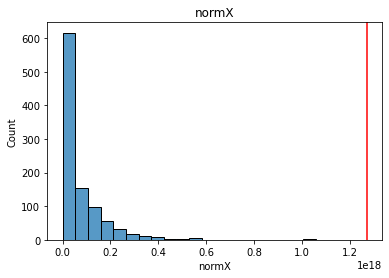

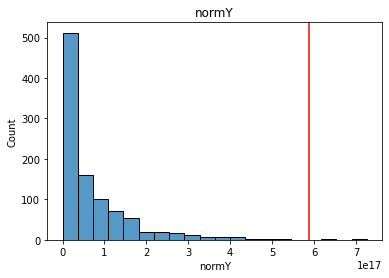

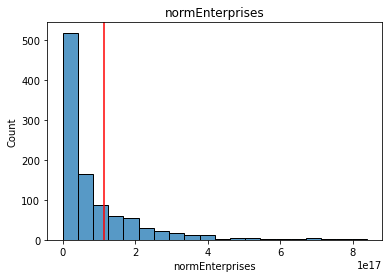

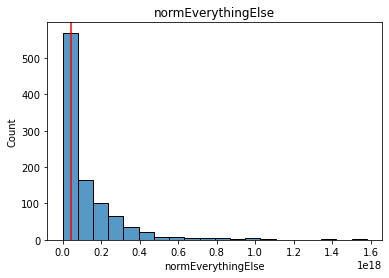

In [232]:
# squared values of distance between mean diff in groups A and B
names = ['normX','normY','normEnterprises','normEverythingElse']

for dim in range(d):
    f, ax = plt.subplots()
    ax = sns.histplot(T_PC_p_table_squared.iloc[:,dim], bins=20)
    plt.axvline( (T_PC[dim])**2 , color="red")
    ax.set_title(names[dim])
    
    fig = ax.get_figure()

#### plots to check if diverging or converging relationship over time in the Urban/Rural divide
03/05/2023

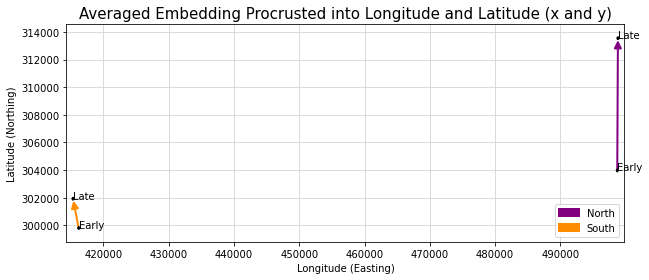

In [233]:
p1 = patches.FancyArrowPatch((summaries['normX'][0], summaries['normY'][0]), (summaries['normX'][2], summaries['normY'][2]), 
                             arrowstyle='-|>', mutation_scale=15, ec="purple", fc="purple", lw=2, label="North")
p2 = patches.FancyArrowPatch((summaries['normX'][1], summaries['normY'][1]), (summaries['normX'][3], summaries['normY'][3]), 
                             arrowstyle='-|>', mutation_scale=15, ec="darkorange", fc="darkorange", lw=2, label="South")

p3 = patches.Ellipse((summaries['normX'][0], summaries['normY'][0]), height=200, width=300, ec="black", fc="black")
p4 = patches.Ellipse((summaries['normX'][1], summaries['normY'][1]), height=200, width=300, ec="black", fc="black")
p5= patches.Ellipse((summaries['normX'][2], summaries['normY'][2]), height=200, width=300, ec="black", fc="black")
p6 = patches.Ellipse((summaries['normX'][3], summaries['normY'][3]), height=200, width=300, ec="black", fc="black")

fig, ax = plt.subplots(figsize=(10,4))
ax.add_patch(p1)
ax.add_patch(p2)
ax.add_patch(p3)
ax.add_patch(p4)
ax.add_patch(p5)
ax.add_patch(p6)

# adjust the x and y limits of the plot
eps = 1000
ax.set_xlim(min(summaries['normX'])-eps, max(summaries['normX'])+eps)
ax.set_ylim(min(summaries['normY'])-eps, max(summaries['normY'])+eps)

#south
plt.annotate(text="Early", xy = (summaries['normX'][1], summaries['normY'][1]))
plt.annotate(text="Late", xy = (summaries['normX'][3], summaries['normY'][3]))
#north
plt.annotate(text="Early", xy = (summaries['normX'][0], summaries['normY'][0]))
plt.annotate(text="Late", xy = (summaries['normX'][2], summaries['normY'][2]))


#ax.set_facecolor('xkcd:pale blue')

plt.xlabel("Longitude (Easting)")
plt.ylabel("Latitude (Northing)")
plt.title("Averaged Embedding Procrusted into Longitude and Latitude (x and y)", fontsize=15)

plt.legend(loc=4)
ax.set_axisbelow(True)
ax.grid(color="lightgrey")

plt.show()

## London/notLondon

In [192]:
df = early.append(late)

#### Change this so that what is "North" in the code now represents "London"

In [193]:
df["NorthIndicator"] = np.where( (df["RGN11NM"] == "London") , 1 ,0) 

In [194]:
# how many LADs are in the north = London
n = df[(df["EarlyIndicator"]==1) & (df["NorthIndicator"]==1)].shape[0]
# how many LADs are in the not London
s = df[(df["EarlyIndicator"]==1) & (df["NorthIndicator"]==0)].shape[0]

print([n,s])

[33, 347]


In [195]:
mean_diff_early = []
mean_diff_late = []

In [196]:
earlyNorthdf = df[ (df["EarlyIndicator"] == 1) & (df["NorthIndicator"] == 1) ]
earlySouthdf = df[ (df["EarlyIndicator"] == 1) & (df["NorthIndicator"] == 0) ]
lateNorthdf = df[ (df["EarlyIndicator"] == 0) & (df["NorthIndicator"] == 1) ]
lateSouthdf = df[ (df["EarlyIndicator"] == 0) & (df["NorthIndicator"] == 0) ]

In [197]:
# calculate values of mean_diff_early_i for all i, i.e. all PCs, and store them in order in a vector
# same for mean_diff_late_i

for i in range(0,d):
    valEarly = (n) * sum( earlyNorthdf.iloc[: ,i])  -  (s) * sum( earlySouthdf.iloc[: ,i])
    valLate = (n) * sum( lateNorthdf.iloc[: ,i])  -  (s) * sum( lateSouthdf.iloc[: ,i])
    mean_diff_early.append(valEarly)
    mean_diff_late.append(valLate)

In [198]:
# calculate T_PC_i
T_PC = np.subtract(mean_diff_early, mean_diff_late)

# length d vector of the subtracted values
T_PC

array([-1.51047763e+09, -1.44239741e+09, -1.05003749e+09,  3.60619180e+08])

In [199]:
T_full_obs = sum(T_PC**2) # this is T_obs
T_obs = T_full_obs # incase I type wrong thing
T_full_obs

5.594677874696807e+18

#### Put it all together in a loop that iterates P times, and stores P items in a `T_full_p_list` item. 

In [200]:
rand_ones = np.array([0,1])
df["A_indicator"] = 0

T_full_p_list = []
P = 5000

# for the individual PCs
T_PC_p_table = pd.DataFrame(columns=['normX','normY','normEnterprises','normEverythingElse'])

In [201]:
random.seed(12)

summariesdf = pd.DataFrame()

for p in range(P):

    for lad in ladslist:
        # to pick 1 timepoints at random for group A, and one for B, i.e. randomly assign to either early or late
        random.shuffle(rand_ones)
        # populates the "A_indicator" column
        df.loc[df["LAD"] == lad,"A_indicator"] = rand_ones

# split the data into the 4 groups (made up of 2 binary labels, 2*2 = 4)
    A_Northdf = df[ (df["A_indicator"] == 1) & (df["NorthIndicator"] == 1) ]
    A_Southdf = df[ (df["A_indicator"] == 1) & (df["NorthIndicator"] == 0) ]
    B_Northdf = df[ (df["A_indicator"] == 0) & (df["NorthIndicator"] == 1) ]
    B_Southdf = df[ (df["A_indicator"] == 0) & (df["NorthIndicator"] == 0) ]
    
    ### THIS STUFF IS TO CONSTRUCT CONFIDENCE INTERVALS
    A_North_summaries = [np.mean(A_Northdf['normX']) , np.mean(A_Northdf['normY']) , np.mean(A_Northdf['normEnterprises']) , np.mean(A_Northdf['normEverythingElse'])]
    A_South_summaries = [np.mean(A_Southdf['normX']) , np.mean(A_Southdf['normY']) , np.mean(A_Southdf['normEnterprises']) , np.mean(A_Southdf['normEverythingElse'])]
    B_North_summaries = [np.mean(B_Northdf['normX']) , np.mean(B_Northdf['normY']) , np.mean(B_Northdf['normEnterprises']) , np.mean(B_Northdf['normEverythingElse'])]
    B_South_summaries = [np.mean(B_Southdf['normX']) , np.mean(B_Southdf['normY']) , np.mean(B_Southdf['normEnterprises']) , np.mean(B_Southdf['normEverythingElse'])]
    summaries = pd.DataFrame (A_North_summaries, columns = ['A_North'])
    summaries['A_South'] = A_South_summaries
    summaries['B_North'] = B_North_summaries
    summaries['B_South'] = B_South_summaries
    summaries.index = (['normX','normY','normEnterprises','normEverythingElse'])
    summaries = summaries.transpose()
    summaries['NorthIndicator'] = [1,0,1,0]
    summaries['NorthorSouth'] = np.where(summaries['NorthIndicator'] >0, 'North', 'South')
    summaries['A_Indicator'] = [1,1,0,0]
    summaries['AorB'] = np.where(summaries['A_Indicator'] >0, 'A', 'B')
    summaries['permutation'] = p
    summariesdf = pd.concat([summariesdf, summaries], axis=0)


    # length d vectors of the difference between the mean locations of the North and South for the 2 groups, A and B 
    mean_diff_A_p = []  #A is early, B is late
    mean_diff_B_p = []
    # calculate values of mean_diff_A_i for all i, i.e. all PCs, and store them in order in a vector
    # same for mean_diff_B_i
    for i in range(0,d):
        valA = (n) * sum( A_Northdf.iloc[: ,i])  -  (s) * sum( A_Southdf.iloc[: ,i])
        valB = (n) * sum( B_Northdf.iloc[: ,i])  -  (s) * sum( B_Southdf.iloc[: ,i])
        mean_diff_A_p.append(valA)
        mean_diff_B_p.append(valB)

    # calculate T_PC_i_p
    T_PC_p = np.subtract(mean_diff_A_p, mean_diff_B_p)

    T_full_p = sum(T_PC_p**2) # this is T_obs

    # values for all dimensions statistic 
    T_full_p_list.append(T_full_p)
    
    # values for individual dimension statistic
    T_PC_p_table.loc[p,:] = T_PC_p

In [202]:
# Testing if time matters in each of the 4 dimensions independently
counters_PCs = []
for dim in range(d):
    counter = 0
    for p in range(P):
        if T_PC_p_table.iloc[p , dim] > T_PC[dim]:
            counter += 1
        else: 
            counter = counter
    counters_PCs.append(counter)

PC_p_values = [(x+1) / (P+1) for x in counters_PCs] # (x+1) add 1 as include the observed value
PC_p_values

[1.0, 1.0, 0.9976004799040192, 0.21295740851829634]

In [203]:
# can square all the values in the `T_PC_p_table` table.
# This is to say we are looking at the value of   (mean_diff_A_p_i - mean_diff_B_p_i)**2
# when we look at row p, column i in the table

T_PC_p_table_squared = T_PC_p_table**2 # #square every value in df

### Histograms for *(mean_diff_A_p_i - mean_diff_B_p_i)$^2$*, where there is a plot for each `i` (the dimension), and `P` counts. 

In [204]:
counters_PCs = []
for dim in range(d):
    counter = 0
    for p in range(P):
        if T_PC_p_table_squared.iloc[p , dim] > (T_PC[dim])**2:
            counter += 1
        else: 
            counter = counter
    counters_PCs.append(counter)

PC_p_square_values = [(x+1) / (P+1) for x in counters_PCs] # (x+1) add 1 as include the observed value

# p-values for each dimension
PC_p_square_values

[0.0001999600079984003,
 0.0001999600079984003,
 0.004199160167966407,
 0.4159168166366727]

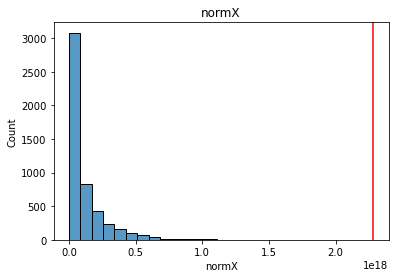

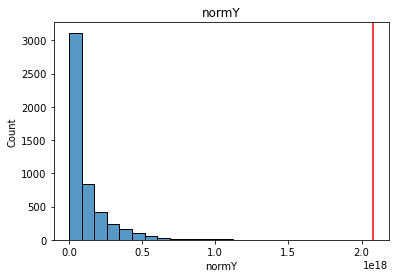

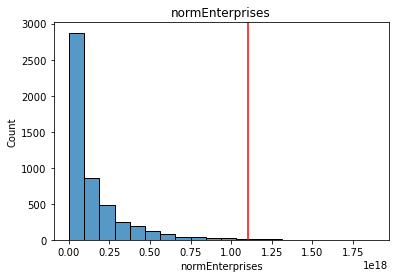

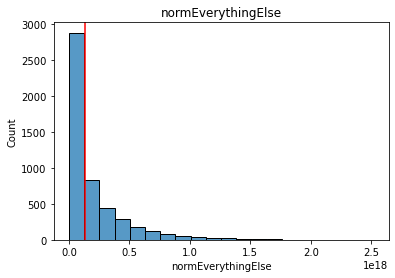

In [205]:
# squared values of distance between mean diff in groups A and B
names = ['normX','normY','normEnterprises','normEverythingElse']

for dim in range(d):
    f, ax = plt.subplots()
    ax = sns.histplot(T_PC_p_table_squared.iloc[:,dim], bins=20)
    plt.axvline( (T_PC[dim])**2 , color="red")
    ax.set_title(names[dim])
    
    fig = ax.get_figure()

#### Check diverging or converging London/notLondon
03/05/2023

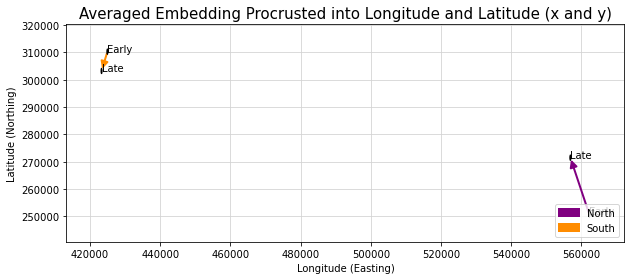

In [209]:
p1 = patches.FancyArrowPatch((summaries['normX'][0], summaries['normY'][0]), (summaries['normX'][2], summaries['normY'][2]), 
                             arrowstyle='-|>', mutation_scale=15, ec="purple", fc="purple", lw=2, label="North")
p2 = patches.FancyArrowPatch((summaries['normX'][1], summaries['normY'][1]), (summaries['normX'][3], summaries['normY'][3]), 
                             arrowstyle='-|>', mutation_scale=15, ec="darkorange", fc="darkorange", lw=2, label="South")

p3 = patches.Ellipse((summaries['normX'][0], summaries['normY'][0]), height=2000, width=300, ec="black", fc="black")
p4 = patches.Ellipse((summaries['normX'][1], summaries['normY'][1]), height=2000, width=300, ec="black", fc="black")
p5= patches.Ellipse((summaries['normX'][2], summaries['normY'][2]), height=2000, width=300, ec="black", fc="black")
p6 = patches.Ellipse((summaries['normX'][3], summaries['normY'][3]), height=2000, width=300, ec="black", fc="black")

fig, ax = plt.subplots(figsize=(10,4))
ax.add_patch(p1)
ax.add_patch(p2)
ax.add_patch(p3)
ax.add_patch(p4)
ax.add_patch(p5)
ax.add_patch(p6)

# adjust the x and y limits of the plot
eps = 10000
ax.set_xlim(min(summaries['normX'])-eps, max(summaries['normX'])+eps)
ax.set_ylim(min(summaries['normY'])-eps, max(summaries['normY'])+eps)

#south
plt.annotate(text="Early", xy = (summaries['normX'][1], summaries['normY'][1]))
plt.annotate(text="Late", xy = (summaries['normX'][3], summaries['normY'][3]))
#north
plt.annotate(text="Early", xy = (summaries['normX'][0], summaries['normY'][0]))
plt.annotate(text="Late", xy = (summaries['normX'][2], summaries['normY'][2]))


#ax.set_facecolor('xkcd:pale blue')

plt.xlabel("Longitude (Easting)")
plt.ylabel("Latitude (Northing)")
plt.title("Averaged Embedding Procrusted into Longitude and Latitude (x and y)", fontsize=15)

plt.legend(loc=4)
ax.set_axisbelow(True)
ax.grid(color="lightgrey")

plt.show()

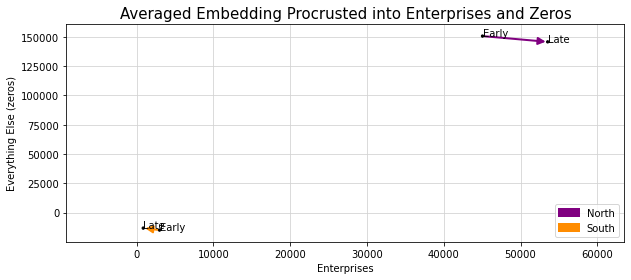

In [210]:
p1 = patches.FancyArrowPatch((summaries['normEnterprises'][0], summaries['normEverythingElse'][0]), (summaries['normEnterprises'][2], summaries['normEverythingElse'][2]), 
                             arrowstyle='-|>', mutation_scale=15, ec="purple", fc="purple", lw=2, label="North")
p2 = patches.FancyArrowPatch((summaries['normEnterprises'][1], summaries['normEverythingElse'][1]), (summaries['normEnterprises'][3], summaries['normEverythingElse'][3]), 
                             arrowstyle='-|>', mutation_scale=15, ec="darkorange", fc="darkorange", lw=2, label="South")

p3 = patches.Ellipse((summaries['normEnterprises'][0], summaries['normEverythingElse'][0]), height=2000, width=300, ec="black", fc="black")
p4 = patches.Ellipse((summaries['normEnterprises'][1], summaries['normEverythingElse'][1]), height=2000, width=300, ec="black", fc="black")
p5= patches.Ellipse((summaries['normEnterprises'][2], summaries['normEverythingElse'][2]), height=2000, width=300, ec="black", fc="black")
p6 = patches.Ellipse((summaries['normEnterprises'][3], summaries['normEverythingElse'][3]), height=2000, width=300, ec="black", fc="black")

fig, ax = plt.subplots(figsize=(10,4))
ax.add_patch(p1)
ax.add_patch(p2)
ax.add_patch(p3)
ax.add_patch(p4)
ax.add_patch(p5)
ax.add_patch(p6)

# adjust the x and y limits of the plot
eps = 10000
ax.set_xlim(min(summaries['normEnterprises'])-eps, max(summaries['normEnterprises'])+eps)
ax.set_ylim(min(summaries['normEverythingElse'])-eps, max(summaries['normEverythingElse'])+eps)

#south
plt.annotate(text="Early", xy = (summaries['normEnterprises'][1], summaries['normEverythingElse'][1]))
plt.annotate(text="Late", xy = (summaries['normEnterprises'][3], summaries['normEverythingElse'][3]))
#north
plt.annotate(text="Early", xy = (summaries['normEnterprises'][0], summaries['normEverythingElse'][0]))
plt.annotate(text="Late", xy = (summaries['normEnterprises'][2], summaries['normEverythingElse'][2]))


#ax.set_facecolor('xkcd:pale blue')

plt.xlabel("Enterprises")
plt.ylabel("Everything Else (zeros)")
plt.title("Averaged Embedding Procrusted into Enterprises and Zeros", fontsize=15)

plt.legend(loc=4)
ax.set_axisbelow(True)
ax.grid(color="lightgrey")

plt.show()